In [ ]:
import torch
import torch.nn as nn
import os
import sys
import numpy as np




print("当前目录:", os.getcwd())
print("Python路径:", sys.path)


sys.path.append('..')

#引用上一层目录的MultiHeadAttentionV2
from MultiHeadAttentionV2 import MultiHeadAttentionV2

In [10]:
#insall tiktoken
#!pip install tiktoken
import tiktoken
#tiktoken支持中文吗？
#tiktoken支持中文编码
enc = tiktoken.get_encoding("cl100k_base")
#字典大小
print(enc.n_vocab)#100277



#读取data.txt文件, 并对其进行编码,每一行为一个样本
with open("data.txt", "r") as f:
    data = f.read()

# 对数据进行编码
encoded_data = [enc.encode(line.strip()) for line in data.splitlines()] # 对每一行进行编码
print(encoded_data[:5]) 

# 对编码后的数据进行padding, 使其长度相同
max_len = max(len(seq) for seq in encoded_data)
padded_data = [seq + [0] * (max_len - len(seq)) for seq in encoded_data]
print(padded_data[:5])

# embedding
d_model = 512
embedding = nn.Embedding(enc.n_vocab, d_model)
# 对padding后的数据进行embedding
embedded_data = embedding(torch.tensor(padded_data))
print(embedded_data[0]) # (num_samples, max_len, d_model)






100277
[[30624, 99849, 46281, 25132, 114, 162, 238, 255, 26892, 48044, 23602, 252, 35304, 37026, 17597, 109, 9554, 27384, 73981, 78244, 54872, 25287, 11571, 10414, 255, 12774, 225, 37026, 17597, 109, 9554, 4178, 44, 32335, 8687, 111, 64467, 59563, 37507, 35287, 6447], [33, 10447, 104, 247, 51611, 76982, 21043, 19361, 28308, 98, 31075, 249, 163, 245, 227, 3922, 164, 236, 104, 13372, 42246, 161, 99, 247, 24326, 232, 98711, 81201, 18476, 90112, 16175, 223, 35287, 6447]]
[[30624, 99849, 46281, 25132, 114, 162, 238, 255, 26892, 48044, 23602, 252, 35304, 37026, 17597, 109, 9554, 27384, 73981, 78244, 54872, 25287, 11571, 10414, 255, 12774, 225, 37026, 17597, 109, 9554, 4178, 44, 32335, 8687, 111, 64467, 59563, 37507, 35287, 6447], [33, 10447, 104, 247, 51611, 76982, 21043, 19361, 28308, 98, 31075, 249, 163, 245, 227, 3922, 164, 236, 104, 13372, 42246, 161, 99, 247, 24326, 232, 98711, 81201, 18476, 90112, 16175, 223, 35287, 6447, 0, 0, 0, 0, 0, 0, 0]]
tensor([[ 1.0716, -0.7580,  0.5571,  ..., 

embedding层是将one-hot编码后的向量映射到低维空间中的稠密向量表示,比如从100277编码到 768，
在 Transformer 架构中的，每个 block，一个“token”对应的向量维度都是 768，知道最后会将最后一层的最后一个 token 映射回 100277，

In [12]:
a = nn.Embedding(100277, 768)
b = nn.Linear(768, 100277)
print(a.weight.shape)
print(b.weight.shape )
# 上面这个b.weight.shape 是 (100277, 768)，linear 在计算的时候，会将参数矩阵进行转置，
# 那为什么不直接将 linear 的参数矩阵设为 (100277, 768) 呢？
# 看到有两个说法，一个说是有利于加载参数，一行的数据在内存里面是连续的，也就是如果 a*b 的话，是a 的行乘以b 的列，那 b 的数据就不是连续的，
# 所以如果先把b转过来，加载就会快，到内存再转一次，具体还没细研究，
# 还有一个说法是反向传播的时候快，这个也得细研究，
# 这个事有点复杂，反正先记住Linear 里面的 weights 是倒过来的就行，
# 如何让模型加速运行比理解模型本身的逻辑要高一个难度，涉及到硬件和数学



torch.Size([100277, 768])
torch.Size([100277, 768])


In [ ]:
#测试一下normalization
input = torch.randn(3,5)
print(input)

layer = nn.Sequential(nn.Linear(5,5), nn.ReLU() )
output = layer(input)
print(output)   


In [ ]:
mean = output.mean(-1)
var = output.var(-1)
var, mean  


# mean variance normalization 相关数学概念
MAD，MAE，都是用来衡量数据的离散程度的，MAD是中位数绝对偏差，MAE是平均绝对误差，
MSE是均方误差，用来衡量数据的离散程度，MSE是对数据的预测值和真实值之间的差异的平方取平均，
MSE的取值范围是0到正无穷大，MSE越小，说明模型的预测值和真实值之间的差异越小，模型的拟合程度越好。
MSE 的公式是：
$$
MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y})^2
$$  

## 无偏估计
无偏估计（样本方差）是指，对一个统计量的估计值，其期望等于被估计的参数的真实值。与 MSE 不同，MSE 是一个有偏估计，因为它的期望不等于被估计的参数的真实值。
偏在什么地方呢？
> MSE 是对数据的预测值和真实值之间的差异的平方取平均，而不是直接取平均。这意味着，MSE 对数据的预测值和真实值之间的差异的平方进行了加权平均，而不是直接对差异进行加权平均。这就导致了 MSE 是一个有偏估计，因为它的期望不等于被估计的参数的真实值。

我的理解是，一个是所有样本-所有样本均值，另外一个是样本-样本的均值，部分样本的均值大概率和所有样本的均值是不一样的，所以偏就偏在这个地方
那这种偏差对最终的计算结果的影响是什么呢？
总体均值，会让全部的差的平方尽可能小，而一旦偏了，大概率，这个差的平方就会被放大，是大概率，不是绝对，所以无偏估计要除以n-1

无偏估计的公式是：
$$
\frac{1}{n-1} \sum_{i=1}^{n} (y_i - \bar{y})^2
$$





## normalization与standardization
感觉这块相关概念是挺乱的，总体上有三种操作，
第一，缩放到均值为 0，方差为 1，这是 standardization 操作
x_standardized = (x - mean) / std, 因为除以了 std，所以新的数据的 std 就为 1，减去的是平均值 mean，所以新的数据的均值就为 0，这就将数据的中心移动到了 0，同时也将数据的方差缩放为了 1，但是数据不一定是正态分布，具体数值范围也不是确定的

std=var(x)=sqrt(mean(x_shifted^2)), 也就是 MSE （Mean Squared Error）的平方根，也就是均方根误差

x - mean就是去中心化，去到中心
var 既然分两部，从侧面也说明，平移不影响方差的计算


第二，直接缩放到[0,1]之间，这是 min-max normalization 操作，也叫 range normalization
x_normalized = (x - min) / (max - min)

第三，直接缩放到[-1,1]之间，这是 min-max normalization 操作，也叫 min-max scaling
x_normalized = 2 * (x - min) / (max - min) - 1，本质上和第二种是一样的，就是将第二种，先放大到[0,2]的范围，然后再左移 1，就得到了[-1,1]的范围

本质上其实两者，第一种，使用了标准差，所以可以叫 standardization，而第二、三种，使用了最大值与最小值的差，所以可以叫 min-max normalization，

这两种不同的处理方式，分母是完全不一样的，归一化是统一缩放了数据之间的差异部分，数据全部加减一部分是会被忽略掉的，
而标准化，是对数据总体分布的一种缩放，






In [ ]:
data = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0, 8.0])
minmax_normalized = (data - min(data)) / (max(data) - min(data))
print(minmax_normalized)
print(data.mean())   
std_normalized = (data - data.mean()) / data.std()

print(std_normalized)

r=data * 2
print(r)

minmax_normalized = (r - min(r)) / (max(r) - min(r))
print(minmax_normalized)

std_normalized = (r - r.mean()) / torch.std(r)
print(std_normalized)

## 方差，协方差，协方差矩阵，PCA，Attention
协方差 covariance，是两个变量之间的统计量，用来衡量两个变量的变化趋势是否一致。
协方差公式：
cov(x, y) = mean((x - mean(x)) * (y - mean(y)))
如果x，y 分布相似的话，xi 与 yi 之间的变化趋势是相似的，那么协方差就会比较大
这个就跟 Attention 是一样的，Attention 是 q 与 k 之间的相似度，相似度越高，就说明 q 与 k 之间的变化趋势是相似的，那么协方差就会比较大

协方差的加权平均：
cov(x, y) = mean(w * (x - mean(x)) * (y - mean(y)))
x，y 权重分配不一样的情况下Wx，Wy,替换上面的w
cov(x, y) = mean(Wx * (x - mean(x)) * (Wy * (y - mean(y))))

如果x，y 是一样的，那么协方差就是方差，公式如下：
cov(x, y) = mean((x - mean(x)) * (y - mean(y))) = mean((x - mean(x))^2) = var(x)

在欧几里得空间中，向量内积的定义为：
dot(x, y) = x^T * y = sum(xi * yi)

如果x，y 本身就已经是均值为零的，也就是已经去中心化的，那么协方差就是内积，公式如下：
cov(x, y) = mean((x - mean(x)) * (y - mean(y))) = mean(x * y) = dot(x, y)/n

从几何上来讲，内积就是向量的长度乘积，也就是向量的模长的乘积，乘以它们之间的夹角的余弦值，
也就是向量的方向是否相同的一个指标， 如果夹角为0度，那么内积就是向量的长度乘积，也就是向量的模长的乘积，
如果夹角为90度，那么内积就是0，因为余弦值为0

协方差矩阵是一个方阵，用来表示多个变量之间的协方差关系。而 Attention 是多个向量之间的点积，
也就是多个向量之间的相似度，相似度越高，就说明向量之间的变化趋势是相似的，那么协方差就会比较大


## covarience Shift







## 为什么 batch normalization 还要 shift 和 scale 这两个参数呢？
shift 和 scale 这两个参数，会对新生成的 distribution 产生一定幅度的放缩和平移效果

normalization 很容易理解，就是对数据进行缩放，让各个样本，各个维度的数据（数值上）统一在一定的范围内
如果数值差异较大，会导致无法进行梯度下降，某个维度或者样本的数据对梯度影响远远大于其他维度或者样本的数据对梯度的影响
就好像，相对平缓的山地相对是可以攀登的，但是如果都是陡峭的悬崖，那就很难从一个点走到另外一个点

那将数据缩放到均值为 0，方差为 1 范围，就能很好地控制数值的分布，为什么还有进行额外的 shift 和 scale 呢？
那只做数值上的 normalization有什么问题呢？
这个问题就是 internal covariance shift 问题，也叫做 internal 分布偏移问题，这个到底是个什么样的问题？

现在模型都是由很多层组成的，尤其是大语言模型，从输入到输出，数据是被每一层参数进行处理
最后计算 loss 之后又反向传播梯度，整个过程是一个乘法过程，数据是被连续处理的，如果大多数的层都放大数据，或者梯度很大，那很可能就训练不下去，数据的数值太大，或者梯度太大
同时也存在另外一种情况，如果每一层都缩小数据，那很可能在小的学习率也学不起来，数据都在一个很多范围内

normalization 会把数据变成均值为 0，方差为 1，这样相对比较小范围的数值，大概率会导致梯度消失，而且sigmoid 函数在 0 附近的梯度是比较小的，
如果数据都在 0 附近，那梯度就会比较小，训练起来就会比较慢

这个问题其实是机器学习中一个非常基础性的问题，就是对数据的操作带来的影响，或者说，网络在堆叠的时候，如何保证正向和反向传播是能够正常进行的，
包括 restnet的残差，也是解决这么一个问题的，这样网络的每一层，不至于完全依赖前一层，防止无限制的扩大或者缩小

每一层有了 shift 和 scale 两个参数，可以对数据进行一定层度的控制，避免数据被放大或者缩小得太多。




# study GELU
FFN是大语言模型中的主要组成部分，每个 Transformer block 中都包含一个 FFN 层，而每个 FFN 则包括两个线性层和一个激活函数
激活函数有很多种类，其中最常用的是 Sigmoid， ReLU， GELU等等
激活函数为模型带来了非线性，

# 非线性对于模型的作用
线性的叠加还是线性，如果模型全是线性层，那相当于在每个维度上画了很多条直线（aix+bi），叠加起来还是直线（a0+a1+...an）x+(b0+b1+...bn）
而多个非线性函数，比如 ReLU 可以拟合任意曲线，具体可以看李宏毅的视频，多个 ReLU 函数的组合，就是神经网络

In [4]:
# GELU激活函数
# GELU(x) = 0.5 * x * (1 + tanh(sqrt(2 / pi) * (x + 0.044715 * x^3)))
# 其中 x 是输入张量的元素，^3 表示 x 的立方，sqrt(2 / pi) 是一个常量，用于缩放输入张量，0.044715 是一个小的常量，用于防止输入张量过大导致 tanh 函数输出饱和。
import math
import torch
import torch.nn as nn

class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
# test GELU, 输入一个3x5的张量，输出一个3x5的张量，
input = torch.tensor([[1.0, 2.0, 3.0, -4.0, 5.0],
                      [2.0, 3.0, 4.0, 5.0, 6.0],
                      [3.0, 4.0, -5.0, 6.0, 7.0]])   
print(input)

layer = GELU()
output = layer(input)
print(output)

tensor([[ 1.,  2.,  3., -4.,  5.],
        [ 2.,  3.,  4.,  5.,  6.],
        [ 3.,  4., -5.,  6.,  7.]])
tensor([[ 8.4119e-01,  1.9546e+00,  2.9964e+00, -7.0214e-05,  5.0000e+00],
        [ 1.9546e+00,  2.9964e+00,  3.9999e+00,  5.0000e+00,  6.0000e+00],
        [ 2.9964e+00,  3.9999e+00, -2.9802e-07,  6.0000e+00,  7.0000e+00]])


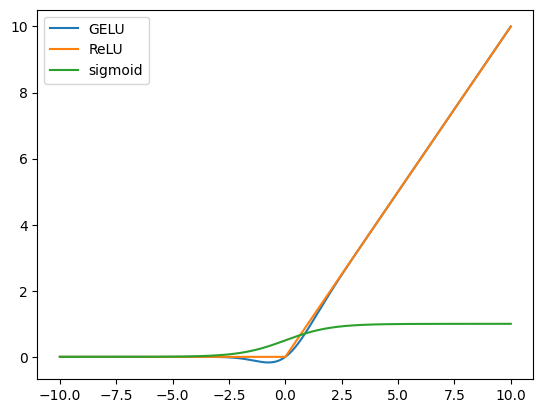

In [6]:
# 用matplotlib 绘制 GELU， ReLU，sigmoid  函数的图像
import matplotlib.pyplot as plt
# 定义 GELU 函数
def gelu(x):
    return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
# 定义 ReLU 函数
def relu(x):
    return torch.maximum(x, torch.zeros_like(x)) # 对输入张量 x 中的每个元素，取其与 0 中的较大值，maximum会比较两个一样大小的张量中每个元素的大小，返回较大值
# 定义 sigmoid 函数
def sigmoid(x):
    # 不能直接math.exp(x), 因为x是一个张量，只能对每个元素进行指数运算
    return 1 / (1 + torch.exp(-x))
# 定义 x 范围
x = torch.linspace(-10, 10, 1000)
# 计算 GELU, ReLU, sigmoid 函数在 x 上的取值
y_gelu = gelu(x)
y_relu = relu(x)
y_sigmoid = sigmoid(x)
# 绘制 GELU, ReLU, sigmoid 函数的图像
plt.plot(x, y_gelu, label='GELU') #参数为 x, y, label，分别为 x 轴坐标，y 轴坐标，图例标签
plt.plot(x, y_relu, label='ReLU')
plt.plot(x, y_sigmoid, label='sigmoid')
plt.legend()
plt.show()  

In [24]:
GPT_CONFIG_124M = {
"vocab size" : 100277,
"context length" : 1024,
"emb_dim" : 768,
"n_heads" : 12,
"n_layers" : 12,
"drop_rate" : 6.1,
"qkv_bias" : False
}

In [25]:
print(torch.arange(0, 5))
print(torch.arange(5))

tensor([0, 1, 2, 3, 4])
tensor([0, 1, 2, 3, 4])
